# Sample Philips Analysis

# Select Image & Phantom and Parse

In [1]:
imagePath = '/Volumes/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf'
phantomPath = '/Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf'

In [2]:
dataFile = open(imagePath, 'rb')
dataSig = list(dataFile.read(8))
phantomFile = open(phantomPath, 'rb')
phantomSig = list(phantomFile.read(8))

In [3]:
# Assert inputted data has Philips signature
assert dataSig == [0,0,0,0,255,255,0,0]
assert phantomSig == [0,0,0,0,255,255,0,0]

In [4]:
destImgFilePath = imagePath.replace('.rf', '.mat')
destPhantomFilePath = phantomPath.replace('.rf', '.mat')

In [8]:
from pyquantus.parse.philipsRf import philipsRfParser

imgShape = philipsRfParser(imagePath)
phantomShape = philipsRfParser(phantomPath)

Opening: /Volumes/CREST Data/David_S_Data/Philips SC 2D/V06_20180626_133351.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:33.147312 seconds.
Parsing header info ...
Elapsed time is 0:00:33.231970 seconds.
Parsing RF data ...
Elapsed time is 0:00:39.437006 seconds.
Organizing based on data type ...
	PostXBR
		Capture_ML:	16x

		Echo_ML:	4x

		CRE:	4

Elapsed time is 0:00:44.855278 seconds.
Done
Opening: /Volumes/CREST Data/David_S_Data/Philips SC 2D/C3P11SED00_20180821_102323.rf
Header information found:
Parsing Fusion RF capture file ...
	File Version: 3
	Header Size: 892 bytes

Elapsed time is 0:00:31.042868 seconds.
Parsing header info ...
Elapsed time is 0:00:31.150965 seconds.
Parsing RF data ...
Elapsed time is 0:00:39.613541 seconds.
Organizing based on data type ...
	PostAGNOS
		Capture_ML:	16x

		Echo_ML:	2x

Elapsed time is 0:00:43.628754 seconds.
Done


In [ ]:
from pyquantus.parse.philipsMat import philips2dRfMatParser

imgDataStruct, imgInfoStruct, refDataStruct, refInfoStruct = philips2dRfMatParser(destImgFilePath, destPhantomFilePath, frame=0)

/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/CLI-Demos/philipsMat.py:91: RuntimeWarning: divide by zero encountered in log10
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore
/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/CLI-Demos/philipsMat.py:91: RuntimeWarning: invalid value encountered in cast
  bmode[:,i] = 20*np.log10(abs(hilbert(echoData[:,i]))) # type: ignore


# ROI Selection (from GUI)

In [6]:
import pickle

pkl_name = "/Volumes/CREST Data/David_S_Data/Philips SC 2D/roi.pkl"

with open(pkl_name, "rb") as f:
    roi_info = pickle.load(f)

/var/folders/5z/myjw1nc12n3g808z31wz0kt80000gn/T/ipykernel_16828/50617539.py:6: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  roi_info = pickle.load(f)


In [7]:
from pathlib import Path

assert roi_info["Image Name"] == Path(destImgFilePath).name
assert roi_info["Phantom Name"] == Path(destPhantomFilePath).name

In [8]:
scSplineX = roi_info["Spline X"]
scSplineY = roi_info["Spline Y"]

# Analysis Config (from GUI)

In [9]:
from pyquantus.qus import AnalysisConfig

pkl_name = "/Volumes/CREST Data/David_S_Data/Philips SC 2D/analysis-config.pkl"

with open(pkl_name, "rb") as f:
    config_info = pickle.load(f)

In [10]:
config = config_info["Config"]

# Spectral Analysis

In [11]:
from pyquantus.qus import UltrasoundImage

ultrasoundImage = UltrasoundImage()
ultrasoundImage.axialResRf = imgInfoStruct.depth / imgDataStruct.rf.shape[0]
ultrasoundImage.lateralResRf = ultrasoundImage.axialResRf * (
    imgDataStruct.rf.shape[0]/imgDataStruct.rf.shape[1]
) # placeholder
ultrasoundImage.bmode = imgDataStruct.bMode
ultrasoundImage.phantomRf = refDataStruct.rf
ultrasoundImage.rf = imgDataStruct.rf
ultrasoundImage.scBmode = imgDataStruct.scBmode
ultrasoundImage.xmap = imgDataStruct.scBmodeStruct.xmap
ultrasoundImage.ymap = imgDataStruct.scBmodeStruct.ymap

In [12]:
from pyquantus.qus import SpectralAnalysis

spectralAnalysis = SpectralAnalysis()
spectralAnalysis.ultrasoundImage = ultrasoundImage
spectralAnalysis.config = config
spectralAnalysis.initAnalysisConfig()
spectralAnalysis.scSplineX = scSplineX
spectralAnalysis.scSplineY = scSplineY

In [13]:
spectralAnalysis.splineToPreSc()
spectralAnalysis.generateRoiWindows()
spectralAnalysis.computeSpecWindows()

/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv2/lib/python3.11/site-packages/pyquantus/qus/analysis.py:254: RuntimeWarning: divide by zero encountered in divide
  w = np.nanmean((r / p) ** 2, axis=1)
/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv2/lib/python3.11/site-packages/pyquantus/qus/analysis.py:255: RuntimeWarning: divide by zero encountered in divide
  u = (w**2) / np.var((r / p) ** 2, axis=1)
/Users/davidspector/Home/Stanford/QuantUS Projects/QuantUS/.venv2/lib/python3.11/site-packages/numpy/_core/_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


0

# Visualizations

In [14]:
from pyquantus.qus import SpectralData
from pyquantus.parse.objects import ScConfig

scConfig = ScConfig()
scConfig.width = imgInfoStruct.width1
scConfig.tilt = imgInfoStruct.tilt1
scConfig.startDepth = imgInfoStruct.startDepth1
scConfig.endDepth = imgInfoStruct.endDepth1

spectralData = SpectralData()
spectralData.spectralAnalysis = spectralAnalysis
spectralData.scConfig = scConfig

In [15]:
spectralData.convertImagesToRGB()

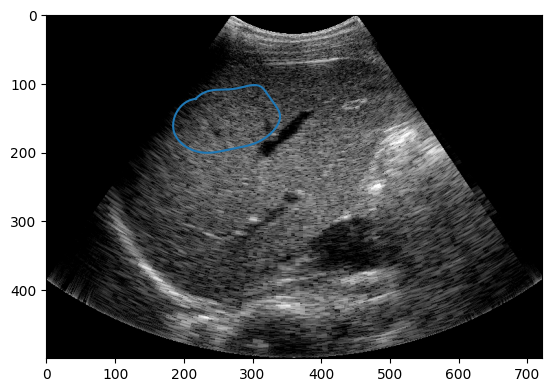

In [16]:
import matplotlib.pyplot as plt

plt.imshow(ultrasoundImage.scBmode)
plt.plot(scSplineX, scSplineY)

In [17]:
spectralData.drawCmaps()
spectralData.scanConvertCmaps()

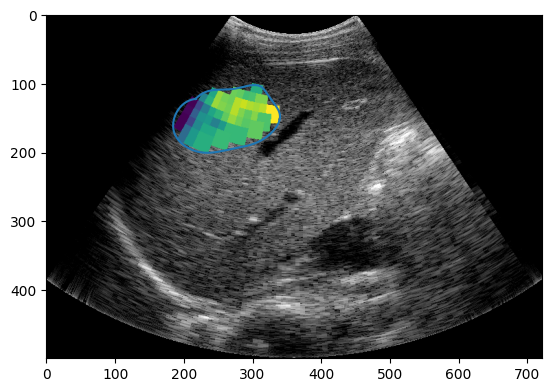

In [18]:
plt.imshow(spectralData.scMbfIm)
plt.plot(scSplineX, scSplineY)

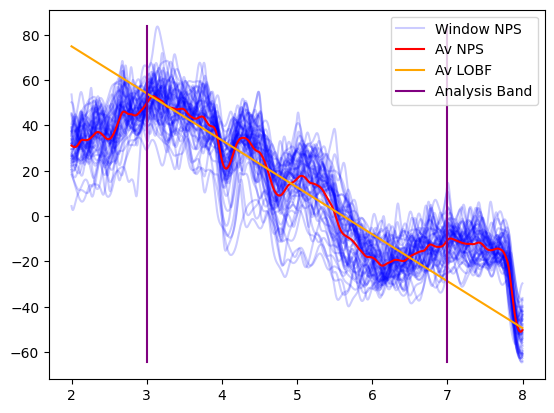

In [19]:
spectralData.plotPsData()

In [20]:
import numpy as np
np.mean(spectralData.mbfArr), np.mean(spectralData.siArr), np.mean(spectralData.ssArr)

(np.float64(12.73425403100898),
 np.float64(116.40197215158261),
 np.float64(-2.0731012673965296e-05))